,nombre,masa,geom
0,Finca la Nijarra,001,"POLYGON ((266262.617 4459496.298, 266259.789 4..."


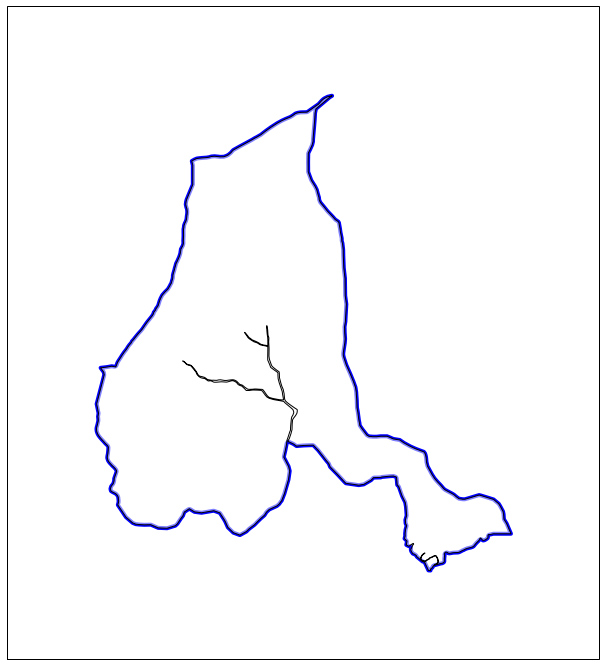

'Finca_la_Nijarra'

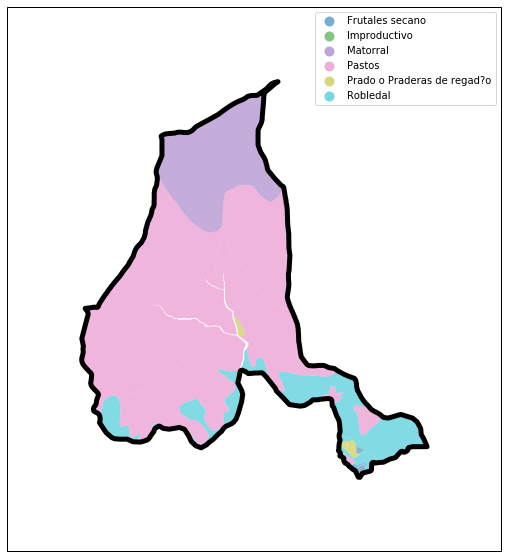

,nombre,masa,geom
0,Sociedad Ganadera La Campana,001,"POLYGON ((268857.237 4463403.636, 268856.657 4..."
1,Sociedad ganadera El Cardal,001,"POLYGON ((269542.580 4461474.247, 269542.290 4..."
2,Sociedad ganadera Estalamancas,001,"POLYGON ((268030.612 4461564.127, 268008.893 4..."
3,None,001,"POLYGON ((266634.995 4462113.298, 266608.205 4..."


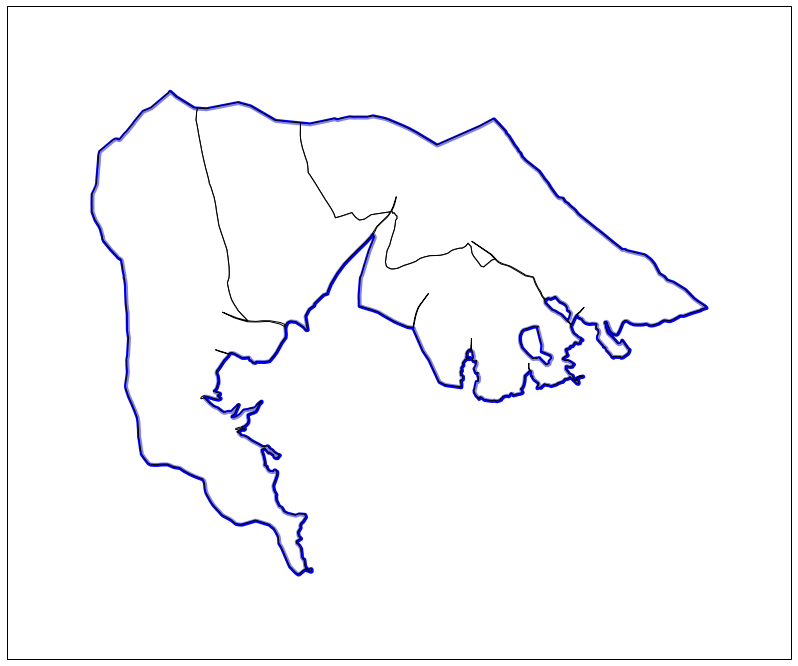

'Sociedad_Ganadera_La_Campana'

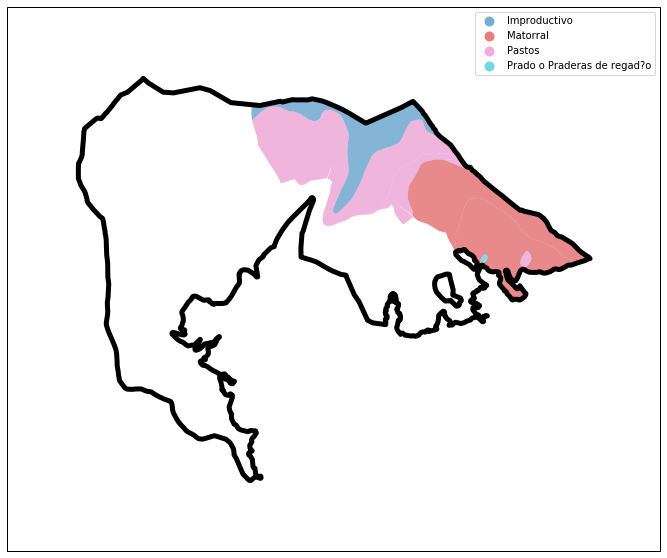

'Sociedad_ganadera_El_Cardal'

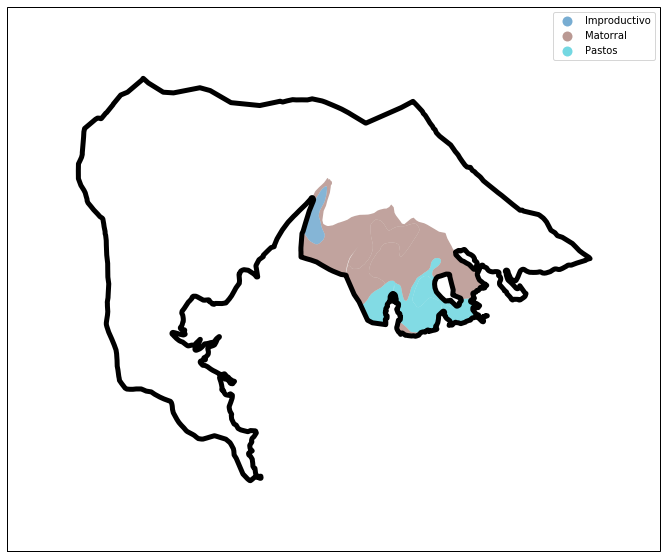

'Sociedad_ganadera_Estalamancas'

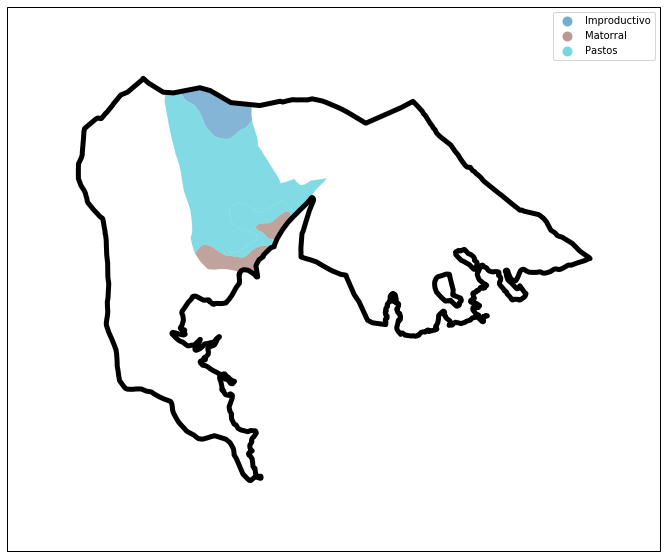

'tornavacas001'

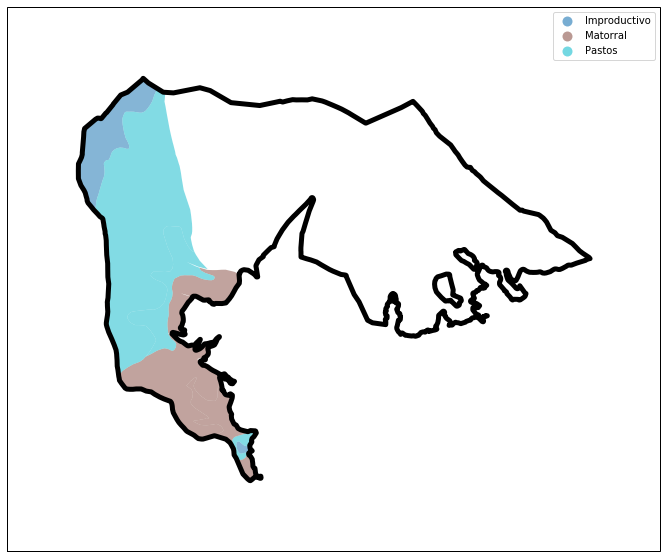

,nombre,geom
0,mup,"MULTIPOLYGON (((276827.517 4447341.821, 276860..."


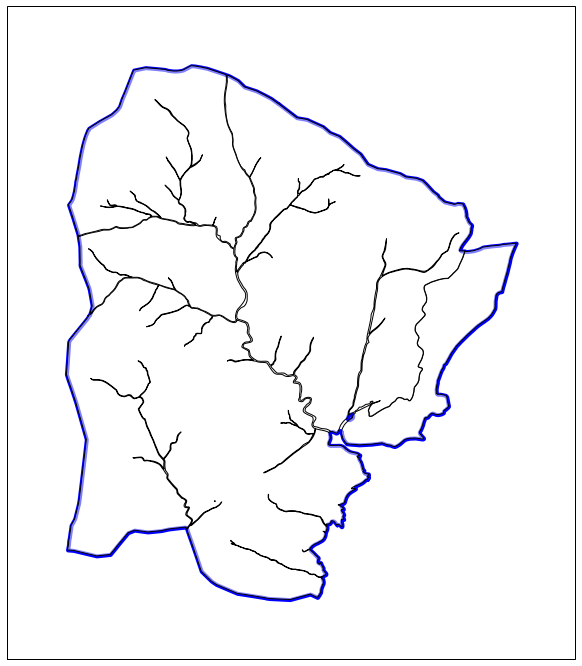

'mup'

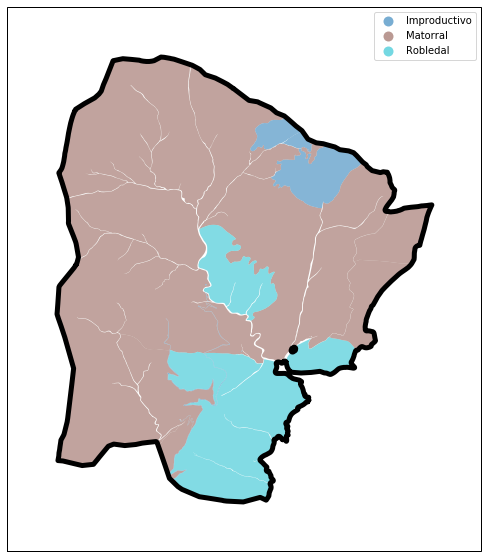

,nombre,masa,geom
0,Finca la Regadera,005,"POLYGON ((296440.569 4455434.466, 296428.990 4..."
1,Finca Encinoso,006,"MULTIPOLYGON (((297839.699 4457159.492, 297830..."
2,None,016,"POLYGON ((295304.294 4456705.287, 295099.645 4..."
3,None,015,"POLYGON ((294532.832 4456043.217, 294733.969 4..."
4,None,011,"POLYGON ((292217.119 4453407.249, 292215.459 4..."
5,None,012,"POLYGON ((290770.567 4455630.753, 290717.617 4..."
6,None,013,"MULTIPOLYGON (((292695.650 4454912.821, 293099..."
7,None,006,"MULTIPOLYGON (((289599.466 4449738.945, 289586..."
8,None,005,"MULTIPOLYGON (((286519.264 4447006.988, 286215..."


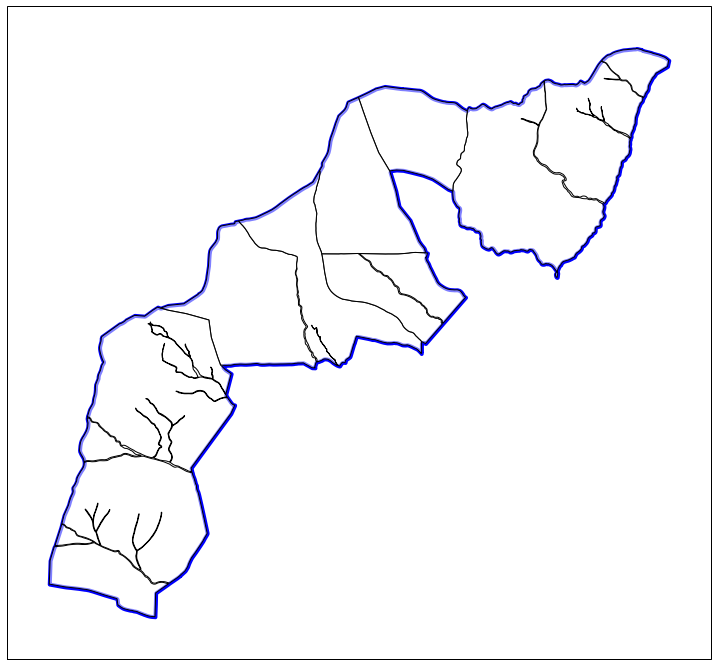

'Finca_la_Regadera'

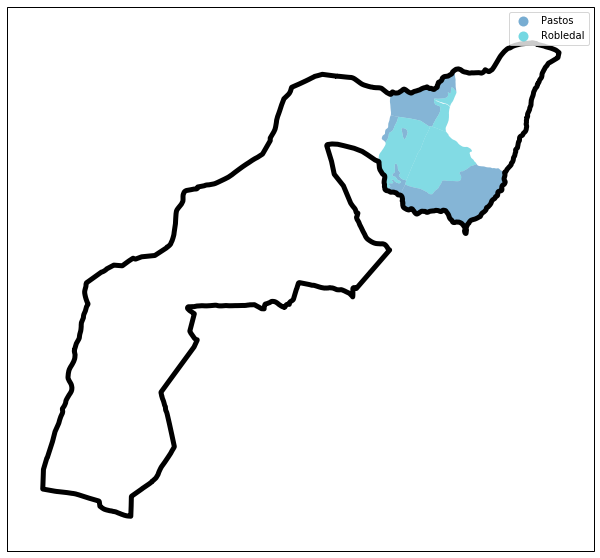

'Finca_Encinoso'

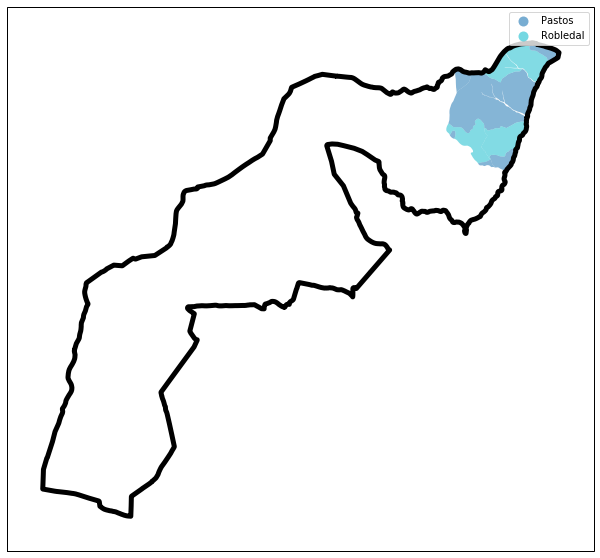

'madrigal016'

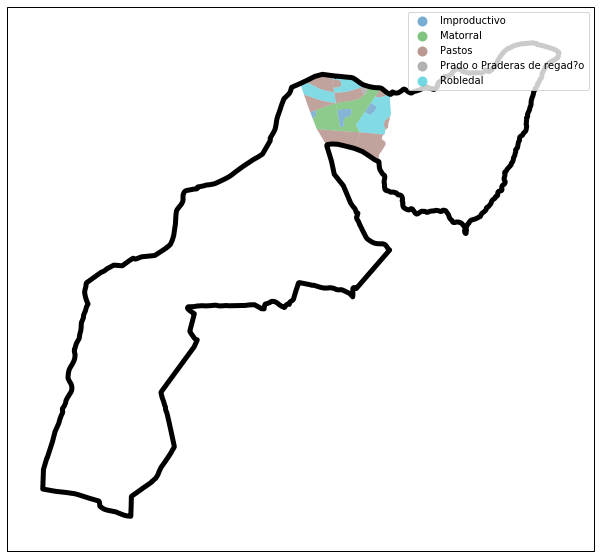

'madrigal015'

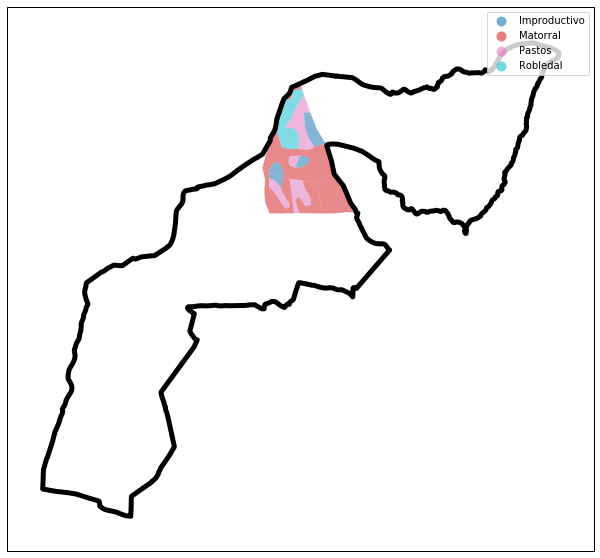

'madrigal011'

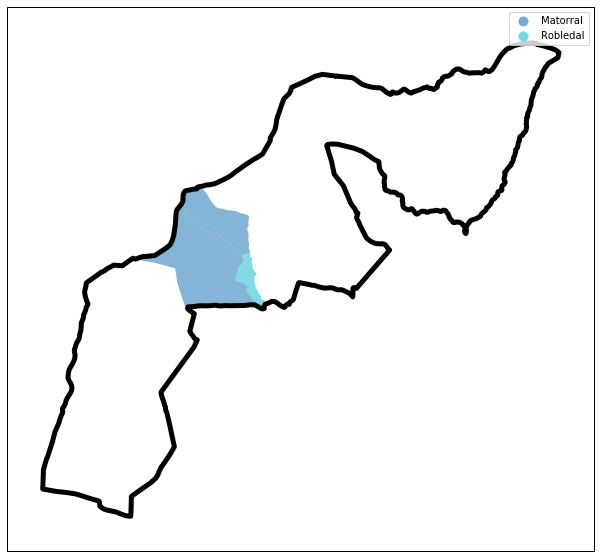

'madrigal012'

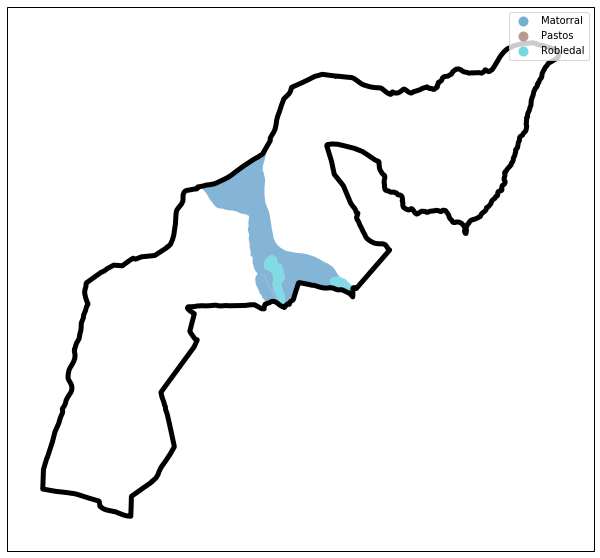

'madrigal013'

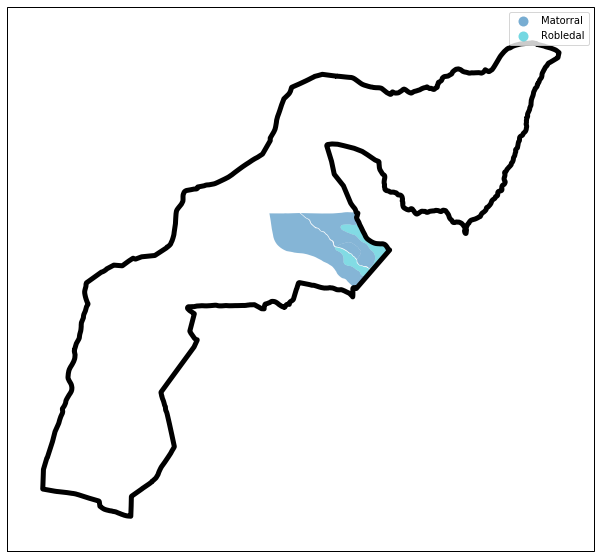

'madrigal006'

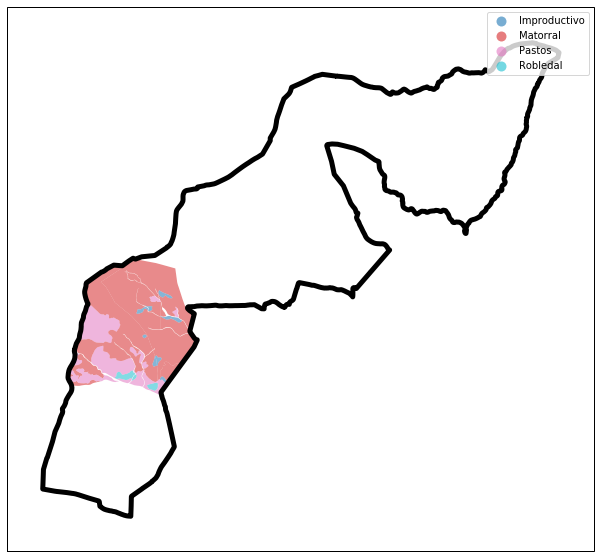

'madrigal005'

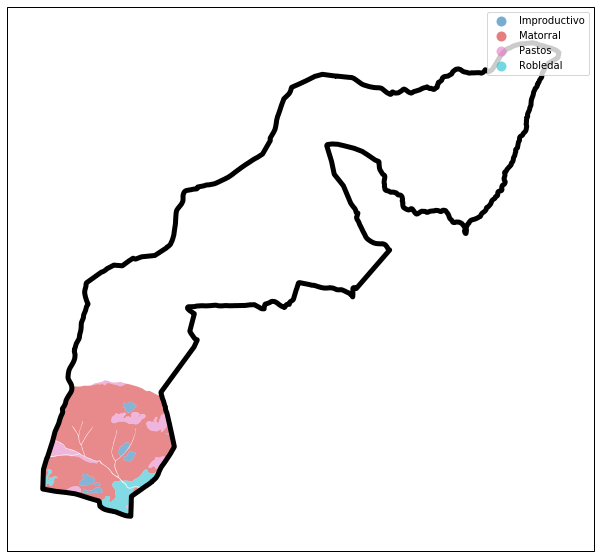

In [13]:
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from IPython.core.display import HTML
from config import config
import datetime

params = config()
conn = psycopg2.connect(**params)

zonas = ['jerte', 'tornavacas', 'losar', 'madrigal']
for zona in zonas:
    if zona == 'madrigal':
        sql = '''
            SELECT nombre, masa, st_union(geom) as geom 
            FROM catastro_mod_{}
            GROUP by nombre, masa
            '''.format(zona)
        sql += ''' union all
                select nombre, masa, st_union(geom) as geom
                from catastro_mod_villanueva
                GROUP by nombre, masa
                '''
        sql += ''' union all
                select nombre, masa, st_union(geom) as geom
                from catastro_mod_valverde
                GROUP by nombre, masa
                '''
    elif zona == 'losar':
        sql = 'select nombre, st_union(geom) as geom from catastro_mod_{} group by nombre'. format(zona)
    else:
        sql = 'select nombre, masa, st_union(geom) as geom from catastro_mod_{} group by nombre, masa'. format(zona)
        
    parcelas = gpd.read_postgis(sql, conn)
    display(parcelas)
    ze = gpd.read_postgis('select * from zona_estudio_{}'.format(zona), conn)

    proj = ccrs.epsg('25830')

    fig = plt.figure(figsize=(16,12))
    ax = plt.axes(projection=proj)

    limites = ze.bounds.loc[0]
    buffer = 1000

    ax.set_extent([limites['minx'] - buffer, 
                   limites['maxx'] + buffer, 
                   limites['miny'] - buffer, 
                   limites['maxy'] + buffer], 
                  crs=proj)
#     ax.add_wms(wms='https://www.ign.es/wms-inspire/mapa-raster', layers=['mtn_rasterizado'])
    ax.add_geometries(ze['geom'], facecolor=(0,0,0,0), edgecolor='blue', linewidth=4, crs=proj)
    ax.add_geometries(parcelas.geom, crs=proj, edgecolor='black', facecolor=(1,1,1,0.5))
#     for index, row in parcelas.iterrows():
#         row.plot()
#         display(type(ze.geom))
#         ax.add_geometries(row.geom, facecolor=(1,1,1,0.5), edgecolor='black', linewidth=1, crs = proj)
#         ax.annotate(s=row['parcela'], xy=(row['coorx'], row['coory']))

#     plt.savefig('static/images/catastro_{}.png'.format(zona), bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)

    for index, parcela in parcelas.iterrows():
        sql = "select * from subparcelas where tipo = 'R'"
        subparcela = gpd.read_postgis(sql, conn)
        s = subparcela[subparcela.intersects(parcela.geom.buffer(-10))]
        fig = plt.figure(figsize=(15,10))
        ax = plt.axes(projection=proj)
        ax.set_extent([limites['minx'] - buffer,
                       limites['maxx'] + buffer,
                       limites['miny'] - buffer,
                       limites['maxy'] + buffer],
                      crs=proj)

#         ax.add_wms(wms='https://www.ign.es/wms-inspire/mapa-raster', layers=['mtn_rasterizado'])
        s.plot(column='denominacion', ax=ax, alpha=0.6, legend=True)
        ax.add_geometries(ze['geom'], facecolor=(1,1,1,0.1), edgecolor='black', linewidth=5, crs=proj)
        display(parcela.nombre.replace(' ','_') if parcela.nombre else zona + parcela.masa)
#         plt.savefig('static/images/subparcela_{}'.format(parcela.nombre.replace(' ','_') if or zona + parcela.masa),
#                     bbox_inches='tight', 
#                     pad_inches=0)
        plt.show()
        plt.close(fig)
        
conn.close()

